In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import plotly.graph_objs as go

The data we will be using has datapoints about people's voices. Each datapoint has information about the person, the frequency of their voice, and statistical information regarding their voice. We will be using Support Vector Machines (SVMs) to predict based on the information provided whether the voice belongs to a male or female.

First we will import the dataset and choose 2 features to use in the SVM. The features we will be using is 'IQR' and 'meanfun'.

In [52]:
df_full = pd.read_csv('voice.csv')
df = df_full[['IQR','meanfun','label']]
display(df.head())
y = df['label']
X = df[['IQR', 'meanfun']]

IQR   meanfun label
0  0.075122  0.084279  male
1  0.073252  0.107937  male
2  0.123207  0.098706  male
3  0.111374  0.088965  male
4  0.127325  0.106398  male

In [62]:
df.shape

(3168, 3)

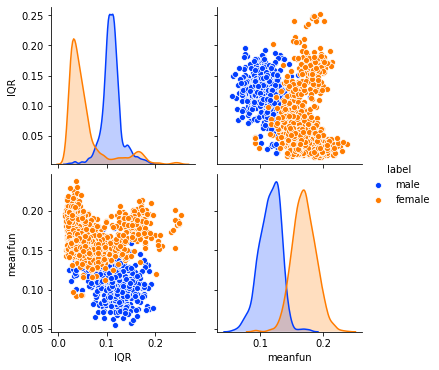

In [53]:
sns.pairplot(df, hue="label",palette="bright")

# Linear SVM

Here we will plot the datapoints and color them pink for female and blue for male.

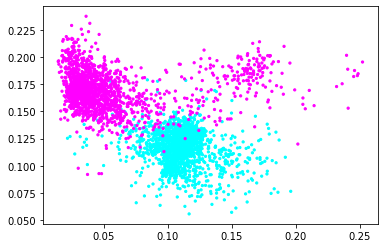

In [133]:
import plotly.express as px
df=df.replace('male', 0)
df=df.replace('female', 1)
X=df.iloc[:,0:2]
y=df['label']
#fig = px.scatter(df, x=X.iloc[:, 0], y=X.iloc[:, 1], color='label')
#fig.show()
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=5, cmap='cool')

By looking at this plot, we can see some somewhat obvoius clusters formed from the data. Our goal is to use SVMs to classify whether the datapoint should be classified as male or female by drawing a margin line through the two clusters. Fortunately we can see that our clusters are fairly seperated in this plot, so it should be fairly easy for the SVM to distinguish which label the voice belongs to. Though there is some overlap, so it will not be perfect.

In [65]:
from sklearn.svm import SVC 
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [66]:
model.support_vectors_

array([[0.12251467, 0.13059833],
       [0.07350474, 0.14274825],
       [0.11956204, 0.13890387],
       [0.07268917, 0.13137633],
       [0.04524976, 0.14181041],
       [0.06189024, 0.12154625],
       [0.07020846, 0.13098333],
       [0.05086627, 0.16515538],
       [0.06368488, 0.15201254],
       [0.07545012, 0.13371745],
       [0.07687909, 0.15910693],
       [0.06682411, 0.1493867 ],
       [0.05688564, 0.14735098],
       [0.09231287, 0.16803788],
       [0.11628306, 0.1336673 ],
       [0.03480944, 0.13800175],
       [0.03504547, 0.12158342],
       [0.10078895, 0.13628051],
       [0.11628306, 0.1336673 ],
       [0.08033712, 0.14703982],
       [0.09430668, 0.14908599],
       [0.10194939, 0.14223686],
       [0.04816166, 0.1728467 ],
       [0.09135593, 0.12979672],
       [0.08541468, 0.13630201],
       [0.08912325, 0.13292829],
       [0.17778819, 0.13823293],
       [0.14256742, 0.14052478],
       [0.06729521, 0.1324576 ],
       [0.06981233, 0.12906434],
       [0.

Here we have "support vectors" for our model. These are essentially the points in our data that will be used as guides on where best to draw the line of seperation between the two clusters.

In [90]:
model.support_vectors_.shape

(249, 2)

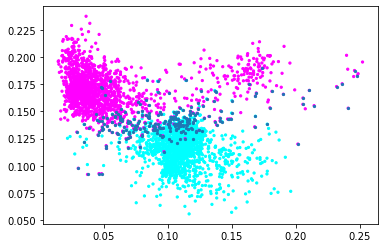

In [134]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=5, cmap='cool')
plt.scatter(model.support_vectors_[:,0],model.support_vectors_[:,1], s=5)

Here we see our support vectors appear mostly between the two clusters, which is expected since this is where the line should be drawn.

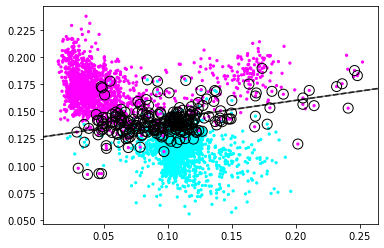

In [140]:
ax = plt.gca()
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=5, cmap='cool')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

Here we see the margin line between the two clusters, with the line and support vectors marked in black. When our model goes to predict whether a voice belongs to a male or female, it will decide using this line. Above the line and the datapoint will be marked 'female', and below it will be marked 'male'. While this would likely give accurate results, we can see that there is some underfitting occuring. We can improve it by making the line non-linear rather than straight.

# Non-Linear SVM

In [138]:
points_colorscale = [
                     [0.0, 'rgb(99, 110, 250)'],
                     [1.0, 'rgb(239, 85, 59)'],
                    ]

points = go.Scatter(
                    x=df['IQR'],
                    y=df['meanfun'],
                    mode='markers',
                    marker=dict(color=y,
                                colorscale=points_colorscale)
                   )
layout = go.Layout(
                   xaxis=dict(range=[-1.05, 1.05]),
                   yaxis=dict(range=[-1.05, 1.05])
                  )

fig = go.Figure(data=[points], layout=layout)
fig.show()

Here we see our data once again, with red being female and blue being male. 

When we implement the SVM to obtain a non-linear split, we have some options to choose for our SVM. For us, we will first use one with an 'rbf' kernal, followed by two SVMs using a 'poly' kernal with degrees = 2 and 3 respectively. This will esentially change the way the SVM decides how best to draw the line seperating the clusters.

In [94]:
(X_train, X_vt, y_train, y_vt) = train_test_split(X, y, test_size=0.4, random_state=0)
(X_validation, X_test, y_validation, y_test) = train_test_split(X_vt, y_vt, test_size=0.5, random_state=0)

### RBF

In [95]:
svm = SVC()

In [96]:
svm.fit(X_train , y_train)

SVC()

In [101]:
decision_colorscale = [
                       [0.0, 'rgb(239,  85,  59)'],
                       [0.5, 'rgb(  0,   0,   0)'],
                       [1.0, 'rgb( 99, 110, 250)']
                      ]

detail_steps = 100

(x_vis_0_min, x_vis_1_min) = (-1.05, -1.05) #X_train.min(axis=0)
(x_vis_0_max, x_vis_1_max) = ( 1.05,  1.05) #X_train.max(axis=0)

x_vis_0_range = np.linspace(x_vis_0_min, x_vis_0_max, detail_steps)
x_vis_1_range = np.linspace(x_vis_1_min, x_vis_1_max, detail_steps)

(XX_vis_0, XX_vis_1) = np.meshgrid(x_vis_0_range, x_vis_0_range)

X_vis = np.c_[XX_vis_0.reshape(-1), XX_vis_1.reshape(-1)]

YY_vis = svm.decision_function(X_vis).reshape(XX_vis_0.shape)

points = go.Scatter(
                    x=df['IQR'],
                    y=df['meanfun'],
                    mode='markers',
                    marker=dict(
                                color=y,
                                colorscale=points_colorscale),
                    showlegend=False
                   )
SVs = svm.support_vectors_
support_vectors = go.Scatter(
                             x=SVs[:, 0],
                             y=SVs[:, 1],
                             mode='markers',
                             marker=dict(
                                         size=15,
                                         color='black',
                                         opacity = 0.1,
                                         colorscale=points_colorscale),
                             line=dict(dash='solid'),
                             showlegend=False
                            )

decision_surface = go.Contour(x=x_vis_0_range,
                              y=x_vis_1_range,
                              z=YY_vis,
                              contours_coloring='lines',
                              line_width=2,
                              contours=dict(
                                            start=0,
                                            end=0,
                                            size=1),
                              colorscale=decision_colorscale,
                              showscale=False
                             )

margins = go.Contour(x=x_vis_0_range,
                     y=x_vis_1_range,
                     z=YY_vis,
                     contours_coloring='lines',
                     line_width=2,
                     contours=dict(
                                   start=-1,
                                   end=1,
                                   size=2),
                     line=dict(dash='dash'),
                     colorscale=decision_colorscale,
                     showscale=False
                    )

fig2 = go.Figure(data=[margins, decision_surface, support_vectors, points], layout=layout)
fig2.show()

RBF looks to have a good margin line

### Poly

Degree = 2

In [104]:
svm_p2 = SVC(kernel='poly', degree=2)

In [105]:
svm_p2.fit(X_train , y_train)

SVC(degree=2, kernel='poly')

In [106]:
YY_vis_p2 = svm_p2.decision_function(X_vis).reshape(XX_vis_0.shape)

SVs_p2 = svm_p2.support_vectors_
support_vectors_p2 = go.Scatter(
                                x=SVs_p2[:, 0],
                                y=SVs_p2[:, 1],
                                mode='markers',
                                marker=dict(
                                            size=15,
                                            color='black',
                                            opacity = 0.1,
                                            colorscale=points_colorscale),
                                line=dict(dash='solid'),
                                showlegend=False
                               )

decision_surface_p2 = go.Contour(x=x_vis_0_range,
                                 y=x_vis_1_range,
                                 z=YY_vis_p2,
                                 contours_coloring='lines',
                                 line_width=2,
                                 contours=dict(
                                               start=0,
                                               end=0,
                                               size=1),
                                 colorscale=decision_colorscale,
                                 showscale=False
                                )

margins_p2 = go.Contour(x=x_vis_0_range,
                        y=x_vis_1_range,
                        z=YY_vis_p2,
                        contours_coloring='lines',
                        line_width=2,
                        contours=dict(
                                      start=-1,
                                      end=1,
                                      size=2),
                        line=dict(dash='dash'),
                        colorscale=decision_colorscale,
                        showscale=False
                       )

fig3 = go.Figure(data=[margins_p2, decision_surface_p2, support_vectors_p2, points], layout=layout)
fig3.show()

Poly with degree = 2 seems to also have a good fit

Degree = 3

In [107]:
svm_p3 = SVC(kernel='poly', degree=3)

In [108]:
svm_p3.fit(X_train , y_train)

SVC(kernel='poly')

In [109]:
YY_vis_p3 = svm_p3.decision_function(X_vis).reshape(XX_vis_0.shape)

SVs_p3 = svm_p3.support_vectors_
support_vectors_p3 = go.Scatter(
                                x=SVs_p3[:, 0],
                                y=SVs_p3[:, 1],
                                mode='markers',
                                marker=dict(
                                            size=15,
                                            color='black',
                                            opacity = 0.1,
                                            colorscale=points_colorscale),
                                line=dict(dash='solid'),
                                showlegend=False
                               )

decision_surface_p3 = go.Contour(x=x_vis_0_range,
                                 y=x_vis_1_range,
                                 z=YY_vis_p3,
                                 contours_coloring='lines',
                                 line_width=2,
                                 contours=dict(
                                               start=0,
                                               end=0,
                                               size=1),
                                 colorscale=decision_colorscale,
                                 showscale=False
                                )

margins_p3 = go.Contour(x=x_vis_0_range,
                        y=x_vis_1_range,
                        z=YY_vis_p3,
                        contours_coloring='lines',
                        line_width=2,
                        contours=dict(
                                      start=-1,
                                      end=1,
                                      size=2),
                        line=dict(dash='dash'),
                        colorscale=decision_colorscale,
                        showscale=False
                       )

fig4 = go.Figure(data=[margins_p3, decision_surface_p3, support_vectors_p3, points], layout=layout)
fig4.show()

Poly with degree = 3 seems to have a good margin as well

### Accuracy Testing

Based on the 3 different SVMs used, all appear to have a good margin line for differentiating the clusters. In order to decide which to use, we will calculate the accuracy of each SVM on the training data.

RBF

In [118]:
yhat_train = svm.predict(X_train)
yhat_validation = svm.predict(X_validation)

In [119]:
print(accuracy_score(yhat_train, y_train), accuracy_score(yhat_validation, y_validation))

0.9652631578947368 0.9716088328075709


Poly (Degree = 2)

In [120]:
yhat_train_p2 = svm_p2.predict(X_train)
yhat_validation_p2 = svm_p2.predict(X_validation)

In [121]:
print(accuracy_score(yhat_train_p2, y_train), accuracy_score(yhat_validation_p2, y_validation))

0.9636842105263158 0.9716088328075709


Poly (Degree = 3)

In [116]:
yhat_train_p3 = svm_p3.predict(X_train)
yhat_validation_p3 = svm_p3.predict(X_validation)

In [117]:
print(accuracy_score(yhat_train_p3, y_train), accuracy_score(yhat_validation_p3, y_validation))

0.9642105263157895 0.973186119873817


We can see that based on these accuracies, the best performing SVM uses the 'poly' kernal with degree = 3. We will coose this model to run our test data.

# Testing Accuracy of Chosen Model

In [122]:
yhat_test_p3 = svm_p3.predict(X_test)
accuracy_score(yhat_test_p3, y_test)

0.9700315457413249

We see that on the test data, it is 97% accurate, which is very good.